In [1]:
import torch
import torchvision

import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# from model.cnn import CNN

EPOCHS = 15
BATCH_SIZE = 256
LEARNING_RATE = 0.001
MODEL = 'CNN'
INPUT_CHANNELS = 1
OUTPUT_SIZE = 10

c:\Users\youfeng\miniconda3\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 找不到指定的程序。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


shape: torch.Size([60000, 28, 28])
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


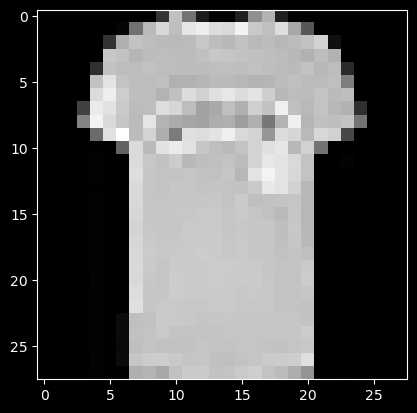

In [14]:

# Step 1: Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: transforms.Normalize(mean=[0.5]*x.shape[0], std=[0.5]*x.shape[0])(x))
])

# load training sets, split the dataset into training and validation sets
_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(_trainset))
val_size = len(_trainset) - train_size
trainset, valset = data.random_split(_trainset, [train_size, val_size])

trainloader = data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = data.DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# load test set
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print('shape:', _trainset.data.shape)
print(torchvision.datasets.FashionMNIST.classes)
plt.imshow(testset.data[19], cmap='gray')

In [ ]:
# Step 2: Define the CNN model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if MODEL == 'CNN':
    class CNN(nn.Module):
        def __init__(self, input_channels : int, output_size : int):
            super(CNN, self).__init__()
            self.cnnBlock1 = nn.Sequential(
                nn.Conv2d(in_channels=input_channels, out_channels=32, 
                        kernel_size=3, stride=1, padding='same'),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )
            self.cnnBlock2 = nn.Sequential(
                nn.Conv2d(in_channels=32, out_channels=64, 
                        kernel_size=3, stride=1, padding='same'),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )
            self.cnnBlock3 = nn.Sequential(
                nn.Conv2d(in_channels=64, out_channels=128, 
                        kernel_size=3, stride=1, padding='same'),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )
            self.fc1 = nn.LazyLinear(out_features=128)
            self.fc2 = nn.LazyLinear(out_features=OUTPUT_SIZE)

        def forward(self, x):
            x = self.cnnBlock1(x)
            x = self.cnnBlock2(x)
            x = self.cnnBlock3(x)
            x = x.reshape(x.shape[0], -1)
            x = F.relu(self.fc1(x)) 
            x = self.fc2(x)
            return x
else:
    raise ValueError('Model not supported: {}'.format(MODEL))

net = CNN(input_channels=INPUT_CHANNELS, output_size=OUTPUT_SIZE).to(device)
print(net)


In [ ]:

# Step 3: Define the loss function, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)


In [ ]:
# Step 4: Train the model
num_epochs = EPOCHS
train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_acc = 0.0  # 用于跟踪最佳验证准确率

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_total = 0
    val_total = 0
    train_correct = 0
    val_correct = 0

    # Training
    net.train()
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item()

    # Validation
    net.eval()
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    # Calculate metrics
    train_loss /= len(trainloader)
    val_loss /= len(valloader)
    train_acc = 100.0 * train_correct / train_total
    val_acc = 100.0 * val_correct / val_total

    # Store metrics for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    # 保存最佳模型
    import os
    checkpoints_dir = "./checkpoints"
    if not os.path.exists(checkpoints_dir):
        os.makedirs(checkpoints_dir)
    
    
    if val_acc > best_val_acc:
        best_model_path = f"./checkpoints/{MODEL}.pth"
        best_val_acc = val_acc
        torch.save(net.state_dict(), best_model_path)


In [ ]:

# Step 5: Plot the training process
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Train')
plt.plot(range(1, num_epochs+1), val_losses, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accs, label='Train')
plt.plot(range(1, num_epochs+1), val_accs, label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Step 6: Evaluate the model on the test set
test_total = 0
test_correct = 0

net.load_state_dict(torch.load(best_model_path))
net.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_acc = 100.0 * test_correct / test_total
print(f"Test Accuracy: {test_acc:.2f}%")